<a href="https://colab.research.google.com/github/ItayShalit/Intro-to-Deep-Learning/blob/main/Intro_to_DL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.nn.utils import skip_init
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import numpy as np
from sys import maxsize
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict

## Part 1


### Data Loading

In [2]:
TRAIN_SIZE = 5000
TEST_SIZE = 1000

gen = torch.Generator()
gen.manual_seed(2022)

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, 
                                        transform = transforms.ToTensor())

sample_train_idx = torch.randint(len(trainset), size=(TRAIN_SIZE,), generator = gen)



testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                       download = True, transform = transforms.ToTensor())
sample_test_idx = torch.randint(len(testset), size=(TEST_SIZE,), generator = gen)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Training an SVM Classifier 

In [3]:
MAX_INTENSITY = 255

train_x = trainset.data/MAX_INTENSITY
train_y = trainset.targets

test_x = testset.data/MAX_INTENSITY
test_y = testset.targets

train_x = train_x.reshape(train_x.shape[0], -1)
train_x = train_x[sample_train_idx,:]
train_y = np.array(train_y)[sample_train_idx]

test_x = test_x.reshape(test_x.shape[0], -1)
test_x = test_x[sample_test_idx,:]
test_y = np.array(test_y)[sample_test_idx]

#### Hyperparameter Tuning

In [ ]:
param_grid1 = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.001],'kernel': ['rbf']}
param_grid2 = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.001],'kernel': ['linear']}

grid1 = GridSearchCV(SVC(),param_grid1, refit=True, verbose=2, n_jobs = -1)
grid2 = GridSearchCV(SVC(),param_grid2, refit=True, verbose=2, n_jobs = -1)

grid1.fit(train_x, train_y)
print("best parameters for grid1: ", grid1.best_params_)

grid2.fit(train_x, train_y)
print("best parameters for grid2: ", grid2.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best parameters for grid1:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
best parameters for grid2:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


#### Training the Models

In [ ]:
# The follwing are the parameters found to be best:
params1 = {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
params2 = {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

rbf_model = SVC(C = params1["C"], kernel = "rbf", gamma = params1["gamma"])
linear_model = SVC(C = params2["C"], kernel = "linear", gamma = params2["gamma"])

rbf_model.fit(train_x, train_y)
linear_model.fit(train_x, train_y)

test_pred_rbf = rbf_model.predict(test_x)
test_pred_linear = linear_model.predict(test_x)

print(f"""accuracy score for linear model is: {accuracy_score(test_y, test_pred_linear)} \n 
        accuracy score for rbf model is: {accuracy_score(test_y, test_pred_rbf)}""")

accuracy score for linear model is: 0.349 
 
        accuracy score for rbf model is: 0.423


## Part 2
### Baseline

In [4]:
class FFNeuralNetwork(nn.Module):
    def __init__(self):
        super(FFNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = nn.Linear(3072, 256) #To save computations, Parameter initialization is currently skipped, 
                                                      #and will be done before training using a custom distribution.
        hidden_layer = nn.Linear(256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.ReLU(),
            hidden_layer,
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = FFNeuralNetwork()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs")
  model = nn.DataParallel(model)

model.to(device)
print(model)

Using cpu device
FFNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [15]:
def train_loop(dataloader, model, loss_fn, optimizer, device, print_progress = False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_progress&(batch % 100 == 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, device, return_results = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        model.eval()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        model.train()
    test_loss /= num_batches
    correct /= size
    if return_results:
      return test_loss, correct

def train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device, figure = None, plot_results = True, label_addition = ''):
  train_accuracy_vals, train_loss_vals, test_accuracy_vals, test_loss_vals = [], [], [], []
  for t in range(epochs):
      train_loop(trainloader, model, loss_fn, optimizer, device)
      train_loss, train_accuracy = test_loop(trainloader, model, loss_fn, device, True)
      test_loss, test_accuracy = test_loop(testloader, model, loss_fn, device, True)
      train_loss_vals.append(train_loss)
      train_accuracy_vals.append(train_accuracy)
      test_loss_vals.append(test_loss)
      test_accuracy_vals.append(test_accuracy)
  if figure == None:
    figure = plt.figure(figsize=(18, 6))
    ax1 = figure.add_subplot(1,2,1)
    ax2 = figure.add_subplot(1,2,2) 
  ax1 = figure.get_axes()[0]
  ax2 = figure.get_axes()[1]
  print("accuracy: ", test_accuracy_vals[-1], " loss: ", test_loss_vals[-1])
  ax1.plot([i for i in range(epochs)], train_accuracy_vals, label = 'train_accuracy ' + label_addition)
  ax1.plot([i for i in range(epochs)], test_accuracy_vals, label = 'test_accuracy ' + label_addition)
  ax2.plot([i for i in range(epochs)], train_loss_vals, label = 'train_loss ' + label_addition)
  ax2.plot([i for i in range(epochs)], test_loss_vals, label = 'test_loss ' + label_addition)
    
  ax1.legend()
  ax2.legend()
  if plot_results:
    figure.show()

#### Hyperparameter Tuning

In [7]:
batch_size = 64

trainsubset = torch.utils.data.Subset(trainset, sample_train_idx)
testsubset = torch.utils.data.Subset(testset, sample_test_idx)
trainloader = torch.utils.data.DataLoader(trainsubset, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader = torch.utils.data.DataLoader(testsubset, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

loss_fn = nn.CrossEntropyLoss()

In [18]:
learning_rate_vals = [1e-1, 1e-2, 1e-3, 1e-4]
init_std_vals = [1e-3, 1e-1, 1]
momentum_param_vals = [0.9, 0.95, 0.99] 

best_loss = maxsize
best_configuration = {'learning_rate':None, 'init_std': None, 'momentum_param': None}

for learning_rate in learning_rate_vals:
  for init_std in init_std_vals:
    for momentum_param in momentum_param_vals:
      torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=init_std)
      torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=init_std)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_param)
      for t in range(50):
        train_loop(trainloader, model, loss_fn, optimizer, device)
      loss, accuracy = test_loop(testloader, model, loss_fn,  device, True)
      print("learning rate: ", learning_rate, "init_std: ", init_std , "momentum_param: ", momentum_param, "loss: ", loss, "accuracy: ", accuracy)
      if loss<best_loss:
        best_loss = loss
        best_configuration["learning rate"] = learning_rate
        best_configuration["momentum_param"] = momentum_param
        best_configuration["init_std"] = init_std

AttributeError: ignored

In [9]:
epochs = 100
best_configuration = {'init_std': 0.1, 'learning rate': 0.001, 'momentum_param': 0.95}


#### Plotting training procces with best configuration

accuracy:  0.38  loss:  1.8391262218356133


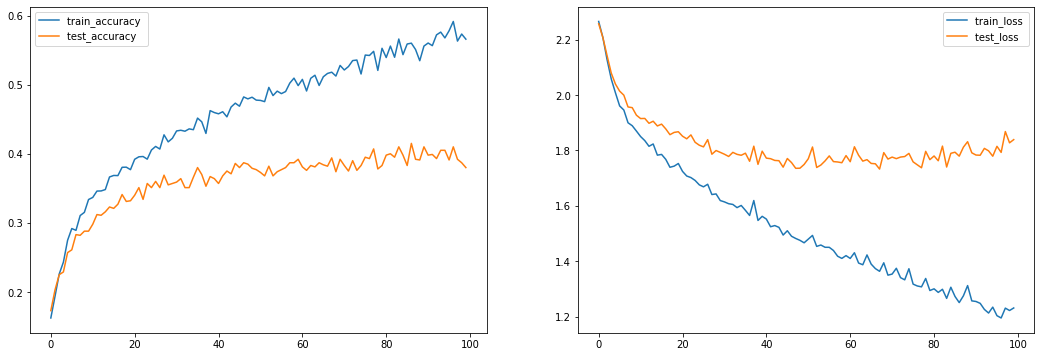

In [ ]:
torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration['init_std'])
torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration['init_std'])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, 100, device)

#### Optimization

accuracy:  0.354  loss:  1.9121456742286682


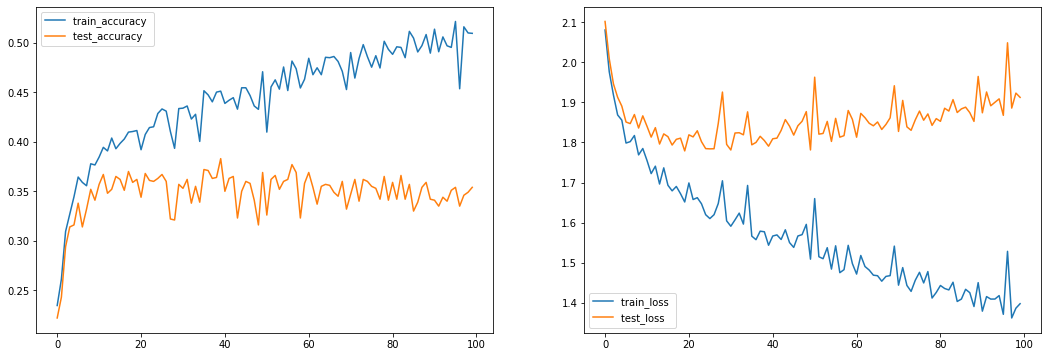

In [ ]:
torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration['init_std'])
torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration['init_std'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_configuration["learning rate"], betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Initialization

accuracy:  0.431  loss:  1.8037258312106133


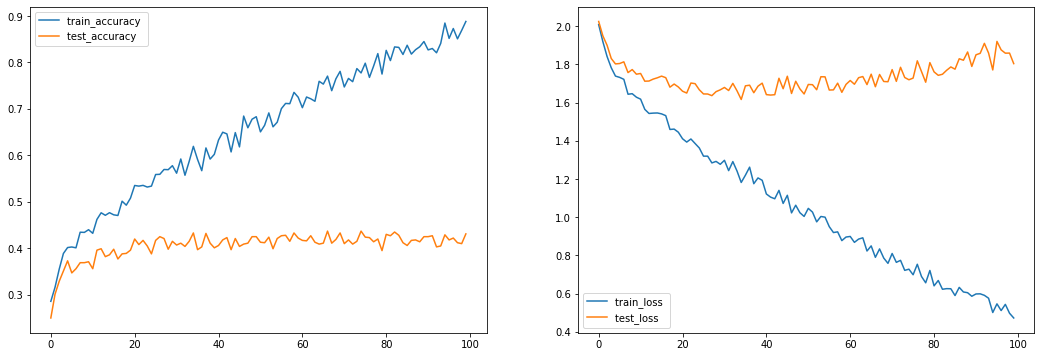

In [ ]:
torch.nn.init.xavier_normal_(model.linear_relu_stack[0].weight)
torch.nn.init.xavier_normal_(model.linear_relu_stack[2].weight)
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Weight Decay

accuracy:  0.386  loss:  1.764792576432228


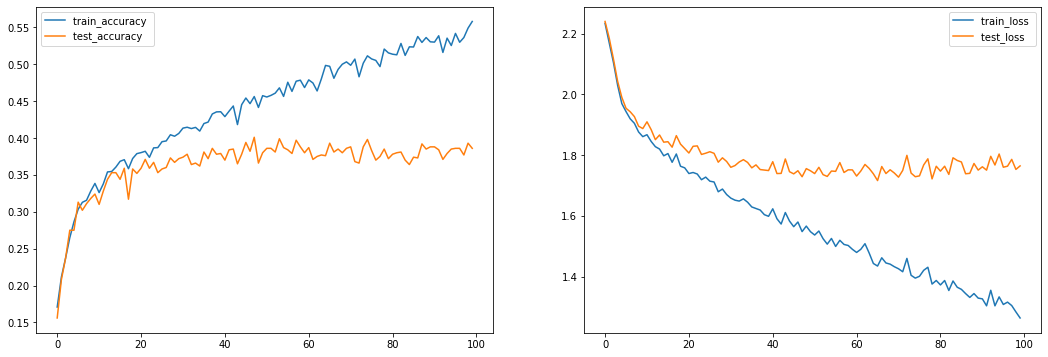

In [ ]:
torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration['init_std'])
torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration['init_std'])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"], weight_decay=1e-4)
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, epochs, device)

#### Dropout

In [16]:
class FFNeuralNetworkDropout(nn.Module):
    def __init__(self):
        super(FFNeuralNetworkDropout, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = nn.Linear(3072, 256) #To save computations, Parameter initialization is currently skipped, 
                                                      #and will be done before training using a custom distribution.
        hidden_layer = nn.Linear(256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.Dropout(0.25),
            nn.ReLU(),
            hidden_layer
            )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

accuracy:  0.425  loss:  1.7957642823457718


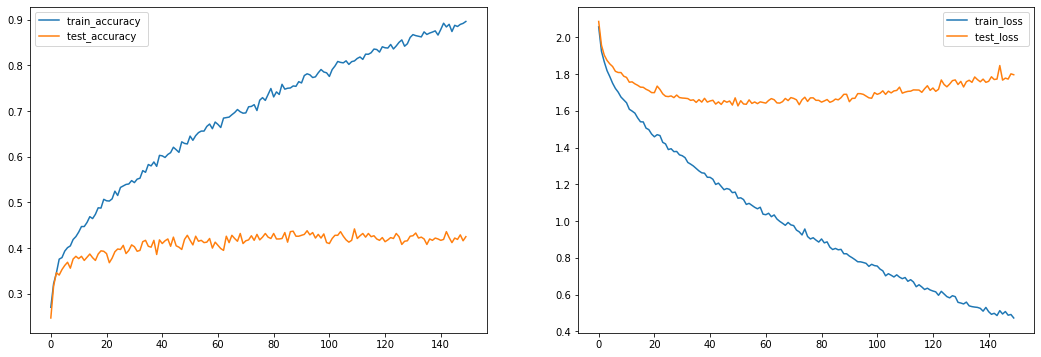

In [17]:
model = FFNeuralNetworkDropout().to(device)
torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration['init_std'])
torch.nn.init.normal_(model.linear_relu_stack[3].weight, mean=0.0, std=best_configuration['init_std'])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, 150, device)

#### PCA Whitening

accuracy:  0.136  loss:  6.447477787733078


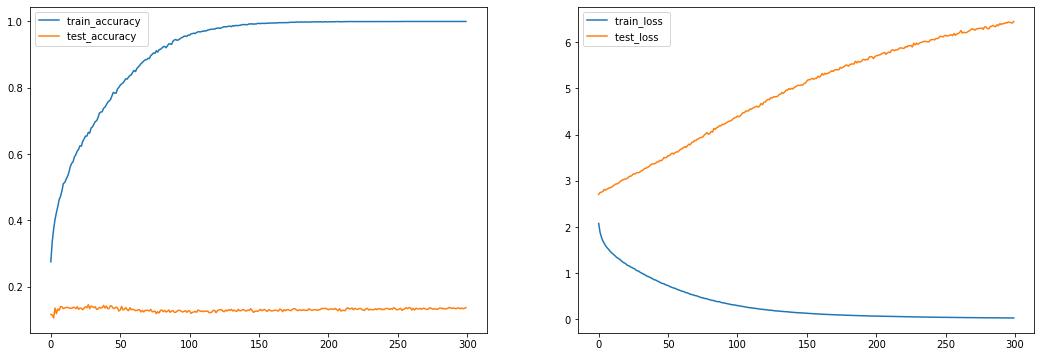

In [14]:
class FFNeuralNetworkPCA(nn.Module):
    def __init__(self):
        super(FFNeuralNetworkPCA, self).__init__()
        self.flatten = nn.Flatten()
        input_layer = nn.Linear(300, 256) #To save computations, Parameter initialization is currently skipped, 
                                                      #and will be done before training using a custom distribution.
        hidden_layer = nn.Linear(256, 10)
        self.linear_relu_stack = nn.Sequential(
            input_layer,
            nn.ReLU(),
            hidden_layer,
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

pca = PCA(n_components=300, whiten=True, random_state=10)
train_x_pca = pca.fit_transform(train_x)
test_x_pca = pca.fit_transform(test_x)
tensor_trainx = torch.Tensor(train_x_pca)
tensor_trainy = torch.Tensor(train_y)
tensor_trainy = tensor_trainy.type(torch.LongTensor)
tensor_testx = torch.Tensor(test_x_pca)
tensor_testy = torch.Tensor(test_y)
tensor_testy = tensor_testy.type(torch.LongTensor)


trainset_pca = torch.utils.data.TensorDataset(tensor_trainx, tensor_trainy)
testset_pca = torch.utils.data.TensorDataset(tensor_testx, tensor_testy)

trainloader_pca = torch.utils.data.DataLoader(trainset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader_pca = torch.utils.data.DataLoader(testset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

model = FFNeuralNetworkPCA().to(device)

torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration['init_std'])
torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration['init_std'])
optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader_pca, testloader_pca, model, loss_fn, optimizer, 300, device)

#### Network Width

In [ ]:
def NNClassGeneratorByWidth(width):
  class FFNeuralNetwork(nn.Module):
      def __init__(self):
          super(FFNeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          input_layer = nn.Linear(3072, width) #To save computations, Parameter initialization is currently skipped, 
                                                        #and will be done before training using a custom distribution.
          hidden_layer = nn.Linear(width, 10)
          self.linear_relu_stack = nn.Sequential(
              input_layer,
              nn.ReLU(),
              hidden_layer,
          )

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  return FFNeuralNetwork

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2) 
width_vals = [6, 10, 12]

for width in width_vals:
  NNClass = NNClassGeneratorByWidth(2**width)
  model = NNClass().to(device)
  torch.nn.init.normal_(model.linear_relu_stack[0].weight, mean=0.0, std=best_configuration['init_std'])
  torch.nn.init.normal_(model.linear_relu_stack[2].weight, mean=0.0, std=best_configuration['init_std'])
  optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
  train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, 150, device, figure = figure, plot_results = False, label_addition = f'width 2^{width}')

figure.show()
  

#### Network Depth

In [ ]:
def NNClassGeneratorByDepth(depth):
  class FFNeuralNetwork(nn.Module):
      def __init__(self):
          super(FFNeuralNetwork, self).__init__()
          self.flatten = nn.Flatten()
          sequence = OrderedDict()
          sequence['lin1'] = nn.Linear(3072, 64)
          for i in range(depth-1):
            sequence[f'rel{i+1}'] = nn.ReLU()
            sequence[f'lin{i+2}'] = nn.Linear(64, 64)
          sequence[f'rel{depth}'] = nn.ReLU()
          sequence[f'rel{depth + 1}'] = nn.Linear(64, 10)
          self.linear_relu_stack = nn.Sequential(sequence)

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  return FFNeuralNetwork

In [ ]:
figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2) 
depth_vals = [6, 10, 12]

for depth in depth_vals:
  NNClass = NNClassGeneratorByDepth(depth)
  model = NNClass().to(device)
  for i in range(len(model.linear_relu_stack)):
    if i%2 == 0:
      torch.nn.init.normal_(model.linear_relu_stack[i].weight, mean=0.0, std=best_configuration['init_std'])
  optimizer = torch.optim.SGD(model.parameters(), lr=best_configuration["learning rate"], momentum=best_configuration["momentum_param"])
  train_and_plot_results(trainloader, testloader, model, loss_fn, optimizer, 150, device, figure = figure, plot_results = False, label_addition = f'depth {depth}')

figure.show()

## Part 3


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.Dropout(0.1), # uncomment this line to enable dropout
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 16, 3),
            nn.Dropout(0.2), # uncomment this line to enable dropout
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Flatten(),
            nn.Linear(784, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

conv_net = ConvNet().to(device)

### Baseline

In [ ]:
# after an initial search with the values above, we narrowed it down to the these options
learning_rate_vals = [0.01, 0.005]
init_std_vals = [0.1]
momentum_param_vals = [0.9, 0.95]
epochs = 20
hyper_parameters_grid_search(model=conv_net, loss_func=conv_net.loss)
print("best configuration:", best_configuration)

In [ ]:
# plot results of best configuration
epochs = 30
init_weights_normal(conv_net, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Optimization

In [ ]:
init_weights_normal(conv_net, best_configuration["init_std"])
optimizer = torch.optim.Adam(conv_net.parameters()) # note we are using default lr of 0.001
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Initialization

In [ ]:
for m in conv_net.modules():
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    torch.nn.init.xavier_normal_(m.weight)
    torch.nn.init.zeros_(m.bias)
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Weight Decay Regularization

In [ ]:
init_weights_normal(conv_net, best_configuration["init_std"])
# 1e-5 is best empirically out of (1e-3, 1e-4, 1e-5) although all are similar. 1e-2 takes too long to fit
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"], weight_decay=1e-5)
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Dropout

In [ ]:
# the following result is from 30 epochs, 0.1 and 0.2 dropout on the first and second layer respectively
epochs = 30
init_weights_normal(conv_net, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

In [ ]:
# yet higher dropout - 0.15 and 0.3
epochs = 50
init_weights_normal(conv_net, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader, testloader, conv_net, conv_net.loss, optimizer, epochs, device)

###Preprocessing

In [ ]:
class ConvNetPCA(nn.Module):
    def __init__(self):
        super(ConvNetPCA, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 64, 3), # for multi-channel PCA, set to 3 input channels
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Conv2d(64, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Flatten(),
            nn.Linear(144, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

conv_net_pca = ConvNetPCA().to(device)

In [ ]:
MAX_INTENSITY = 255
train_x = trainset.data/MAX_INTENSITY
train_x = train_x[sample_train_idx,:].transpose((3, 0, 1, 2)).reshape(3, 5000, -1)
train_y = np.array(trainset.targets)[sample_train_idx]

test_x = testset.data/MAX_INTENSITY
test_x = test_x[sample_test_idx,:].transpose((3, 0, 1, 2)).reshape(3, 1000, -1)
test_y = np.array(testset.targets)[sample_test_idx]

pca = PCA(n_components=225, whiten=True) # see here why 100 components: https://towardsdatascience.com/integration-of-dimension-reduction-methods-and-neural-network-for-image-classification-96281963fe24
train_x_pca = np.ndarray((3, 5000, 15, 15))
test_x_pca = np.ndarray((3, 1000, 15, 15))
for i in range(3):
  train_x_pca[i] = pca.fit_transform(train_x[i]).reshape(train_x[i].shape[0], 15, 15)
  test_x_pca[i] = pca.fit_transform(test_x[i]).reshape(test_x[i].shape[0], 15, 15)
tensor_trainx = torch.Tensor(train_x_pca.transpose((1, 0, 2, 3)))
tensor_trainy = torch.tensor(train_y)
tensor_testx = torch.Tensor(test_x_pca.transpose((1, 0, 2, 3)))
tensor_testy = torch.tensor(test_y)

trainset_pca = torch.utils.data.TensorDataset(tensor_trainx,tensor_trainy)
testset_pca = torch.utils.data.TensorDataset(tensor_testx,tensor_testy)
trainloader_pca = torch.utils.data.DataLoader(trainset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader_pca = torch.utils.data.DataLoader(testset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

In [ ]:
epochs = 30
init_weights_normal(conv_net_pca, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net_pca.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader_pca, testloader_pca, conv_net_pca, conv_net_pca.loss, optimizer, epochs, device)

In [ ]:
# flat PCA attempt
MAX_INTENSITY = 255
train_x = trainset.data/MAX_INTENSITY
train_x = train_x[sample_train_idx,:].reshape(len(sample_train_idx), -1)
train_y = np.array(trainset.targets)[sample_train_idx]

test_x = testset.data/MAX_INTENSITY
test_x = test_x[sample_test_idx,:].reshape(len(sample_test_idx), -1)
test_y = np.array(testset.targets)[sample_test_idx]

pca = PCA(n_components=225, whiten=True)
train_x_pca = pca.fit_transform(train_x).reshape(train_x.shape[0], 15, 15)
test_x_pca = pca.fit_transform(test_x).reshape(test_x.shape[0], 15, 15)

tensor_trainx = torch.Tensor(train_x_pca).reshape(train_x.shape[0], 1, 15, 15)
tensor_trainy = torch.tensor(train_y)
tensor_testx = torch.Tensor(test_x_pca).reshape(test_x.shape[0], 1, 15, 15)
tensor_testy = torch.tensor(test_y)

trainset_pca = torch.utils.data.TensorDataset(tensor_trainx,tensor_trainy)
testset_pca = torch.utils.data.TensorDataset(tensor_testx,tensor_testy)
trainloader_pca = torch.utils.data.DataLoader(trainset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)
testloader_pca = torch.utils.data.DataLoader(testset_pca, batch_size = batch_size,
                                          num_workers=2, shuffle = True)

In [ ]:
init_weights_normal(conv_net_pca, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net_pca.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
train_and_plot_results(trainloader_pca, testloader_pca, conv_net_pca, conv_net_pca.loss, optimizer, epochs, device)

###Network Width

In [ ]:
class ConvNetWide(ConvNet):
    def __init__(self):
        super(ConvNetWide, self).__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Flatten(),
            nn.Linear(3136, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

class ConvNetWider(ConvNet):
    def __init__(self):
        super(ConvNetWider, self).__init__()
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 512, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True),
            nn.Flatten(),
            nn.Linear(12544, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

conv_net_wide = ConvNetWide().to(device)
conv_net_wider = ConvNetWider().to(device)

In [ ]:
epochs = 50
init_weights_normal(conv_net_wide, best_configuration["init_std"])
init_weights_normal(conv_net_wider, best_configuration["init_std"])
optimizer = torch.optim.SGD(conv_net_wide.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
wide_results = train_and_return_results(trainloader, testloader, conv_net_wide, conv_net_wide.loss, optimizer, epochs, device)
optimizer = torch.optim.SGD(conv_net_wider.parameters(), lr=best_configuration["learning_rate"], momentum=best_configuration["momentum_param"])
wider_results = train_and_return_results(trainloader, testloader, conv_net_wider, conv_net_wider.loss, optimizer, epochs, device)

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2) 
ax1 = figure.get_axes()[0]
ax2 = figure.get_axes()[1]
ax1.plot([i for i in range(epochs)], wide_results[0], label = 'train accuracy wide')
ax1.plot([i for i in range(epochs)], wide_results[2], label = 'test accuracy wide')
ax1.plot([i for i in range(epochs)], wider_results[0], label = 'train accuracy WIDER')
ax1.plot([i for i in range(epochs)], wider_results[2], label = 'test accuracy WIDER')
ax2.plot([i for i in range(epochs)], wide_results[1], label = 'train loss wide')
ax2.plot([i for i in range(epochs)], wide_results[3], label = 'test loss wide')
ax2.plot([i for i in range(epochs)], wider_results[1], label = 'train loss WIDER')
ax2.plot([i for i in range(epochs)], wider_results[3], label = 'test loss WIDER')
ax1.legend()
ax2.legend()
figure.show()


###Network Depth

In [ ]:
class ConvNetDeep(ConvNet):
    def __init__(self, depth, linear_size):
        super(ConvNetDeep, self).__init__()
        layers = [nn.Conv2d(3, 2**(depth + 4), 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, ceil_mode=True)]
        current_channels = 2**(depth + 4)
        for i in range(depth - 1):
          layers += [nn.Conv2d(current_channels, 2**(depth + 3 - i), 3),
            nn.ReLU()]
          if i == int(depth / 2) - 1: # only add one additional max pooling layer because dimensions get ever smaller
            layers.append(nn.MaxPool2d(2, stride=2, ceil_mode=True))
          current_channels = 2**(depth + 3 - i)
        layers += [nn.MaxPool2d(2, stride=2, ceil_mode=True),
                   nn.Flatten(),
                   nn.Linear(linear_size, 10)]
        self.classifier = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.classifier(x)

conv_net_3 = ConvNetDeep(3, 288).to(device)
conv_net_4 = ConvNetDeep(4, 128).to(device)
conv_net_5 = ConvNetDeep(5, 32).to(device)

In [ ]:
epochs = 50
init_weights_normal(conv_net_3, best_configuration["init_std"])
init_weights_normal(conv_net_4, best_configuration["init_std"])
init_weights_normal(conv_net_5, best_configuration["init_std"])
optimizer = torch.optim.Adam(conv_net_3.parameters())
results_3 = train_and_return_results(trainloader, testloader, conv_net_3, conv_net_3.loss, optimizer, epochs, device)
optimizer = torch.optim.Adam(conv_net_4.parameters())
results_4 = train_and_return_results(trainloader, testloader, conv_net_4, conv_net_4.loss, optimizer, epochs, device)
optimizer = torch.optim.Adam(conv_net_5.parameters())
results_5 = train_and_return_results(trainloader, testloader, conv_net_5, conv_net_5.loss, optimizer, epochs, device)

figure = plt.figure(figsize=(18, 6))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2) 
ax1 = figure.get_axes()[0]
ax2 = figure.get_axes()[1]
ax1.plot([i for i in range(epochs)], results_3[0], label = 'train accuracy 3')
ax1.plot([i for i in range(epochs)], results_3[2], label = 'test accuracy 3')
ax1.plot([i for i in range(epochs)], results_4[0], label = 'train accuracy 4')
ax1.plot([i for i in range(epochs)], results_4[2], label = 'test accuracy 4')
ax1.plot([i for i in range(epochs)], results_5[0], label = 'train accuracy 5')
ax1.plot([i for i in range(epochs)], results_5[2], label = 'test accuracy 5')
ax2.plot([i for i in range(epochs)], results_3[1], label = 'train loss 3')
ax2.plot([i for i in range(epochs)], results_3[3], label = 'test loss 3')
ax2.plot([i for i in range(epochs)], results_4[1], label = 'train loss 4')
ax2.plot([i for i in range(epochs)], results_4[3], label = 'test loss 4')
ax2.plot([i for i in range(epochs)], results_5[1], label = 'train loss 5')
ax2.plot([i for i in range(epochs)], results_5[3], label = 'test loss 5')
ax1.legend()
ax2.legend()
figure.show()

In [ ]:
print(max(results_3[2]))
print(max(results_4[2]))
print(max(results_5[2]))

print(max(results_3[0]))
print(max(results_4[0]))
print(max(results_5[0]))

print(results_3[1][49])
print(results_4[1][49])
print(results_5[1][49])

print(results_3[3][49])
print(results_4[3][49])
print(results_5[3][49])